In [1]:
#IN HERE I JUST CREATE THE LABELING BECAUSE THE LABELING FOR THE GENDER I MISSED FROM THE VERY FIRST BEGINGN 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

# 1. Load Data (using your structure)
def load_data(data_dir):
    class_names = ['ÿ£ŸÜÿ´Ÿâ', 'ÿ∞ŸÉÿ±']  # 0 for ÿ£ŸÜÿ´Ÿâ, 1 for ÿ∞ŸÉÿ±
    X, Y = [], []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 100))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            X.append(img_array)
            Y.append(label)
    return np.array(X), np.array(Y)


In [3]:
#CNN MODEL ARCHITECTURE 

In [4]:
def create_gender_model():
    model = models.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 100, 3)),
        layers.MaxPooling2D((2, 2)),# nafs el depth bs size of the image is decreased 
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),# depth hykoon 1
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')# 1 here means the output expected should be 1 output only 
        # tanh what is the diff between sigmoid and the tanh
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
#IN HERE WE MAKE THE CROSS VALIDATION SO IT TRAINS BETTER ON 5 SPLITS 

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

def run_cross_validation(X, Y, n_splits=5, epochs=100, batch_size=32):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    all_val_preds = []
    all_val_true = []
    best_model = None
    best_score = 0

    os.makedirs('cv_results', exist_ok=True)

    for train_idx, val_idx in kfold.split(X, Y):
        print(f'\n=== Fold {fold_no}/{n_splits} ===')
        
        model = create_gender_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
        
        history = model.fit(
            X[train_idx], Y[train_idx],
            validation_data=(X[val_idx], Y[val_idx]),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        
        scores = model.evaluate(X[val_idx], Y[val_idx], verbose=0)
        val_preds = (model.predict(X[val_idx]) > 0.5).astype(int)
        
        all_val_preds.extend(val_preds)
        all_val_true.extend(Y[val_idx])
        
        if scores[1] > best_score:
            best_score = scores[1]
            best_model = model
            print(f"New best model with val_accuracy: {best_score:.4f}")
        
        plt.figure()
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title(f'Fold {fold_no} Accuracy')
        plt.legend()
        plt.savefig(f'cv_results/fold_{fold_no}_history.png')
        plt.close()
        
        fold_no += 1

    if best_model:
        best_model.save('cv_results/best_gender_model.h5')
        print(f"\nSaved best model with validation accuracy: {best_score:.4f}")
    
    print("\n=== Overall Cross-Validation Metrics ===")
    print(classification_report(all_val_true, all_val_preds, target_names=['ÿ£ŸÜÿ´Ÿâ', 'ÿ∞ŸÉÿ±']))

    cm = confusion_matrix(all_val_true, all_val_preds)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['ÿ£ŸÜÿ´Ÿâ', 'ÿ∞ŸÉÿ±'])
    plt.yticks(tick_marks, ['ÿ£ŸÜÿ´Ÿâ', 'ÿ∞ŸÉÿ±'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.savefig('cv_results/confusion_matrix.png')
    plt.close()

    return best_model

In [7]:
# IN HERE IM TRAINING THE MODEL 

In [8]:
if __name__ == "__main__":
    data_dir = r"C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender"
    X, Y = load_data(data_dir)
    
    print(f"Total samples: {len(X)}")
    print(f"Class distribution: ÿ£ŸÜÿ´Ÿâ={sum(Y==0)}, ÿ∞ŸÉÿ±={sum(Y==1)}")

    # Cross-validation training with early stopping
    best_model = run_cross_validation(X, Y)

    # Final training on all data with early stopping
    final_model = create_gender_model()
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=8, 
    restore_best_weights=True,
    verbose=1
)


    final_model.fit(X, Y, epochs=100, batch_size=32, callbacks=[early_stop])
    final_model.save('final_gender_model.h5')


Total samples: 3233
Class distribution: ÿ£ŸÜÿ´Ÿâ=1611, ÿ∞ŸÉÿ±=1622

=== Fold 1/5 ===


c:\Users\alhas\Downloads\LABELED IDSSSS\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 301ms/step - accuracy: 0.5911 - loss: 0.6550 - val_accuracy: 0.9459 - val_loss: 0.5897
Epoch 2/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 289ms/step - accuracy: 0.9270 - loss: 0.1891 - val_accuracy: 0.9366 - val_loss: 0.4198
Epoch 3/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 289ms/step - accuracy: 0.9558 - loss: 0.1127 - val_accuracy: 0.8980 - val_loss: 0.3342
Epoch 4/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 293ms/step - accuracy: 0.9654 - loss: 0.0980 - val_accuracy: 0.9413 - val_loss: 0.2215
Epoch 5/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 285ms/step - accuracy: 0.9716 - loss: 0.0729 - val_accuracy: 0.9861 - val_loss: 0.0739
Epoch 6/100
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 278ms/step - accuracy: 0.9810 - loss: 0.0487 - val_accuracy: 0.8825


Saved best model with validation accuracy: 1.0000

=== Overall Cross-Validation Metrics ===
              precision    recall  f1-score   support

        ÿ£ŸÜÿ´Ÿâ       1.00      1.00      1.00      1611
         ÿ∞ŸÉÿ±       1.00      1.00      1.00      1622

    accuracy                           1.00      3233
   macro avg       1.00      1.00      1.00      3233
weighted avg       1.00      1.00      1.00      3233



c:\Users\alhas\Downloads\LABELED IDSSSS\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 191ms/step - accuracy: 0.5791 - loss: 0.6521
Epoch 2/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 191ms/step - accuracy: 0.9338 - loss: 0.1598
Epoch 3/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 187ms/step - accuracy: 0.9507 - loss: 0.1164
Epoch 4/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 186ms/step - accuracy: 0.9810 - loss: 0.0646
Epoch 5/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 185ms/step - accuracy: 0.9796 - loss: 0.0551
Epoch 6/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 185ms/step - accuracy: 0.9892 - loss: 0.0281
Epoch 7/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 188ms/step - accuracy: 0.9822 - loss: 0.0460
Epoch 8/100
102/102 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 180ms

In [9]:
#IN HERE WE MAKE THE PREDICTION 

Model path exists: True
Test folder exists: True


‚úÖ Successfully loaded model from cv_results/best_gender_model.h5
üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (537).jpg


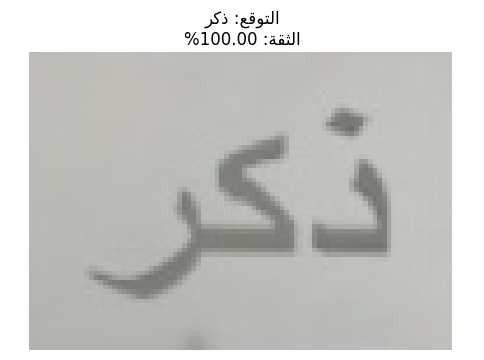

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (538).jpg


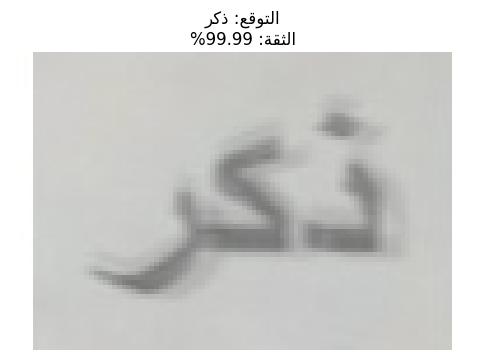

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (539).jpg


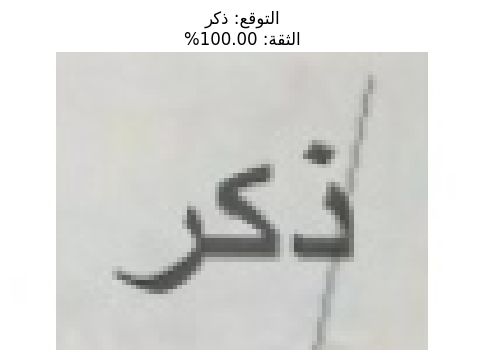

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (540).jpg


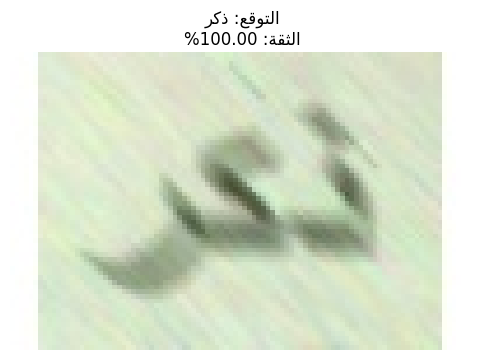

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (541).jpg


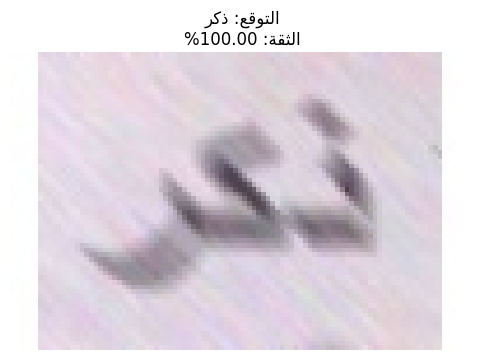

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (542).jpg


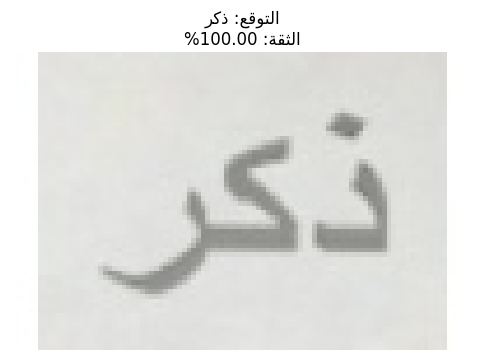

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (543).jpg


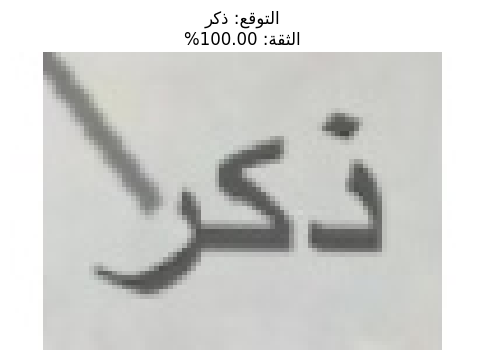

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (544).jpg


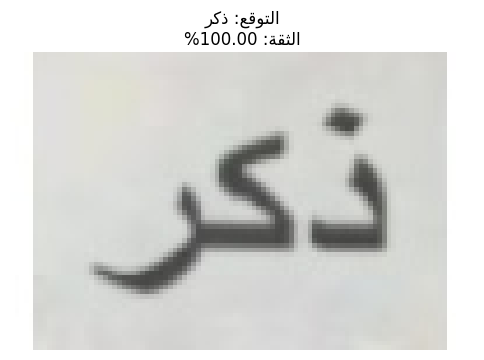

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (545).jpg


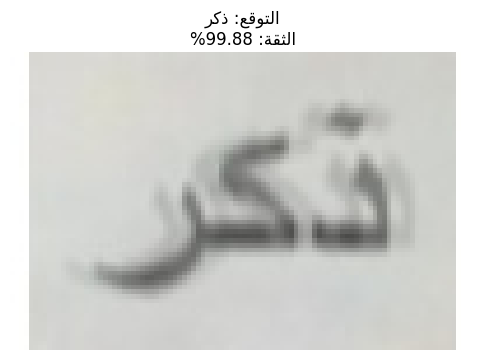

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (546).jpg


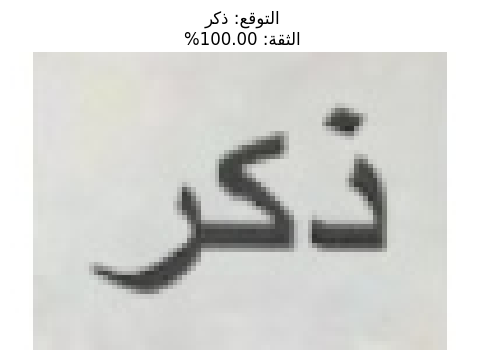

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (547).jpg


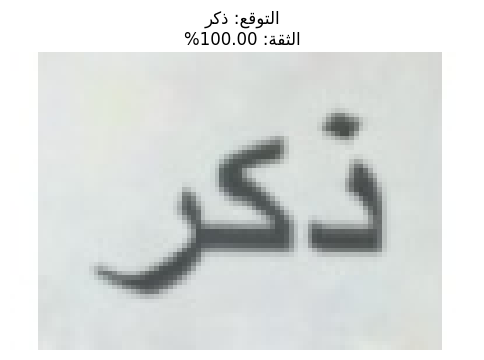

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (548).jpg


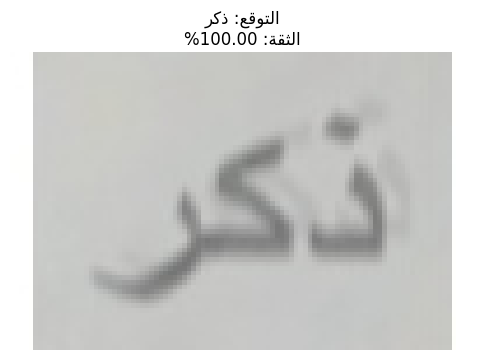

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (549).jpg


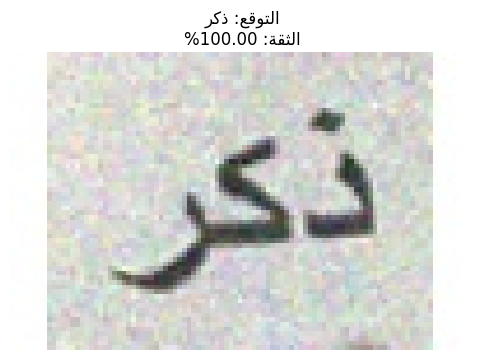

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (550).jpg


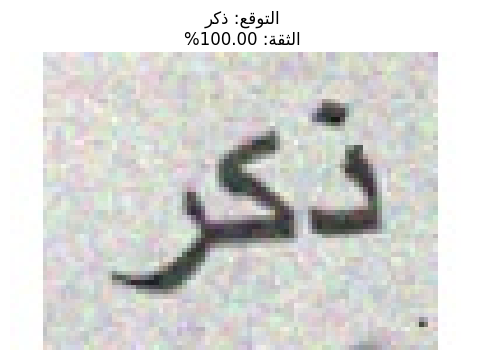

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (551).jpg


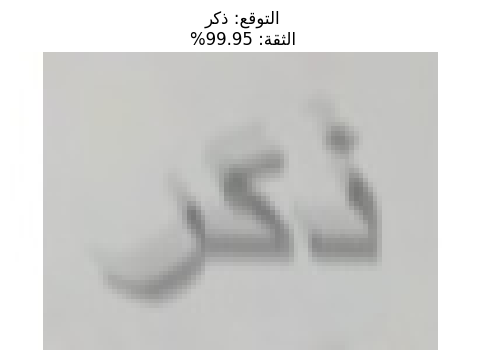

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (552).jpg


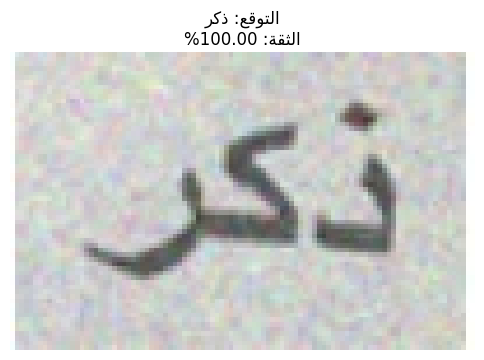

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (553).jpg


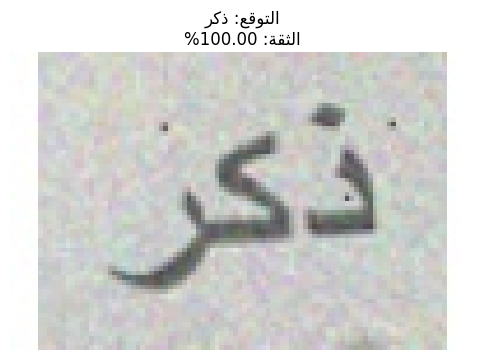

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (554).jpg


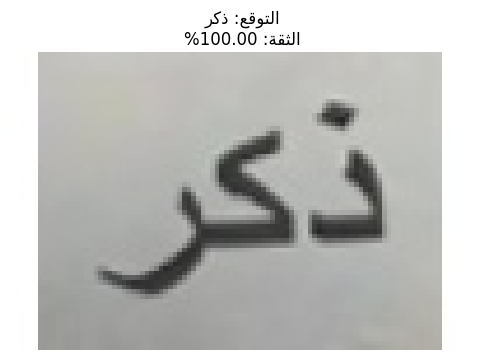

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (555).jpg


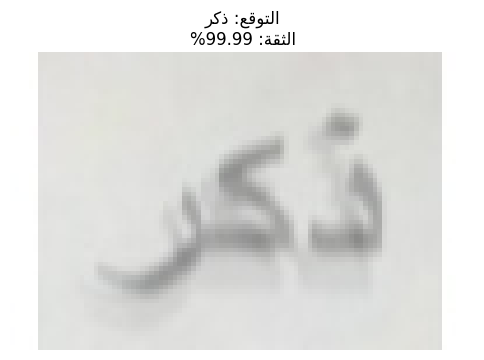

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (556).jpg


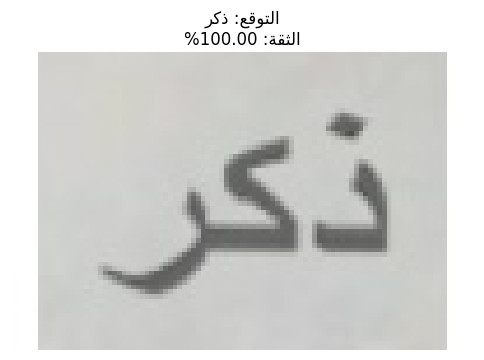

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (557).jpg


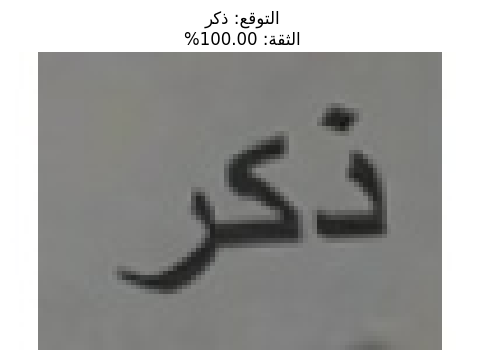

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_36_egypt_id_130_1zoo (558).jpg


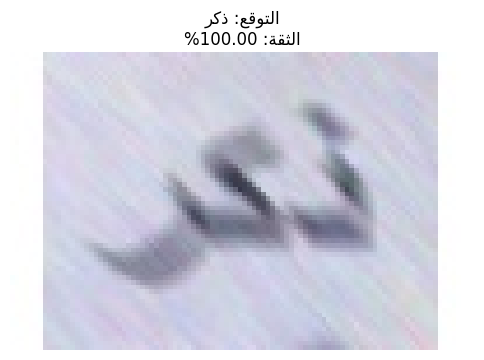

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_404_egypt_id_462_1.jpg


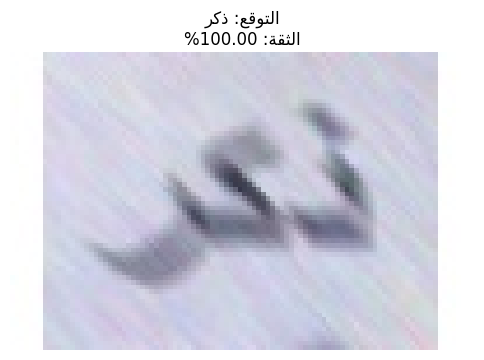

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_407_egypt_id_465_2.jpg


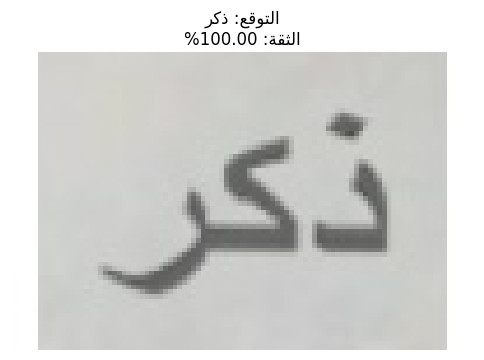

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_408_egypt_id_466_1.jpg


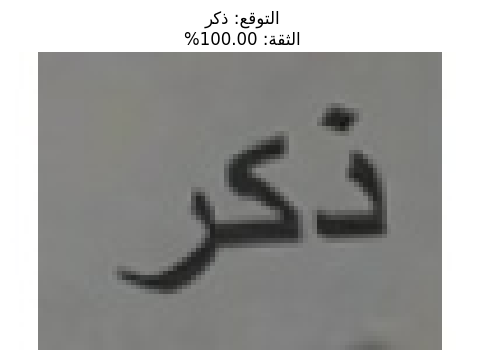

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_418_egypt_id_475_2.jpg


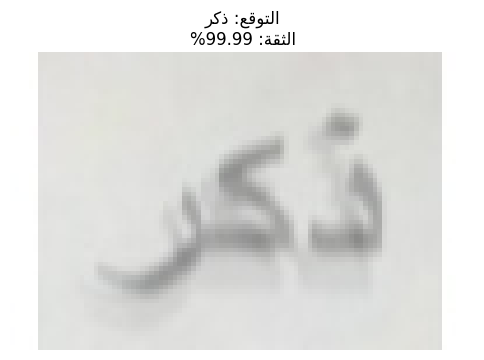

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_434_egypt_id_49_1.jpg


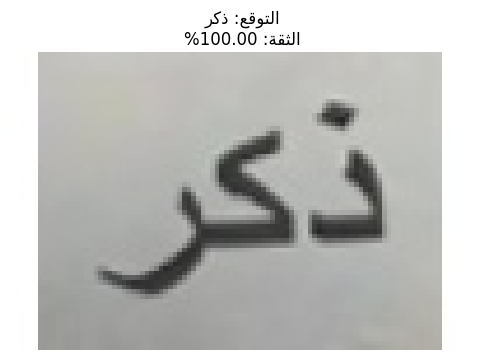

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_441_egypt_id_496_1.jpg


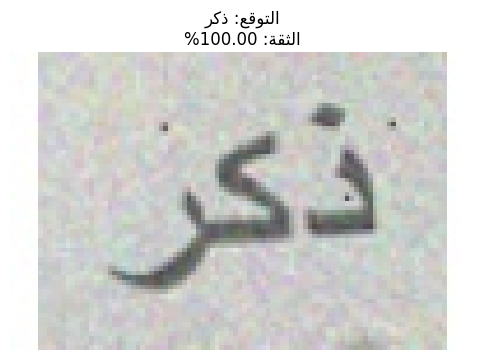

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_446_egypt_id_50_0.jpg


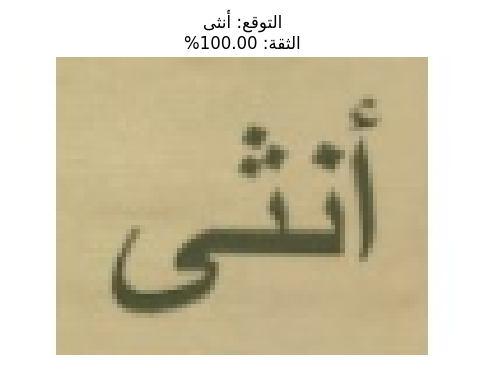

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_449_egypt_id_52_2.jpg


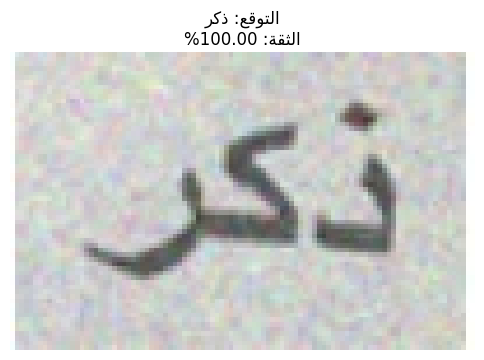

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_44_egypt_id_138_0.jpg


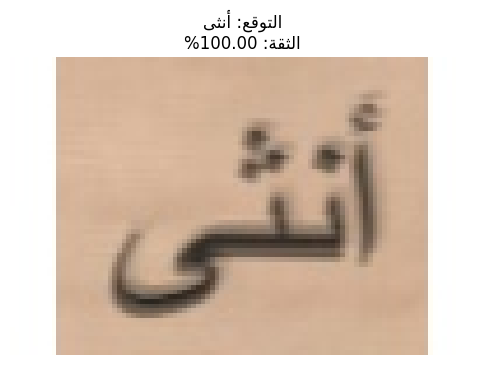

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_453_egypt_id_56_0.jpg


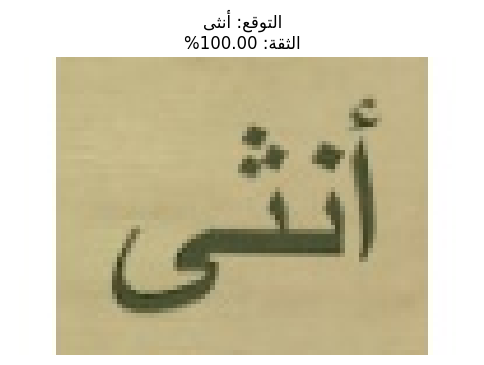

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_453_egypt_id_56_1.jpg


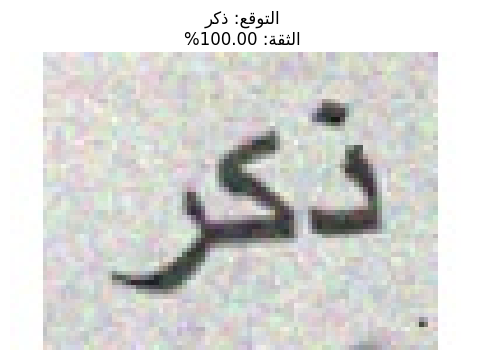

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_454_egypt_id_57_0.jpg


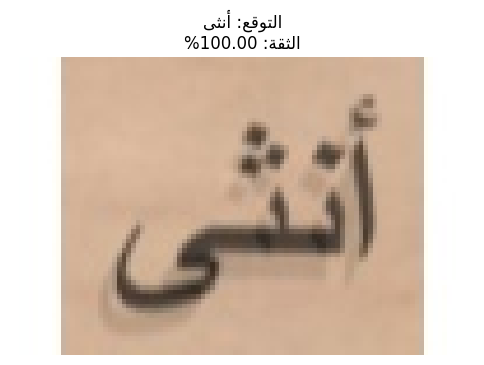

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_455_egypt_id_58_0.jpg


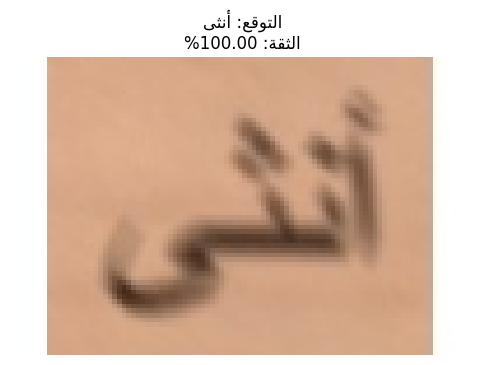

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_456_egypt_id_59_2.jpg


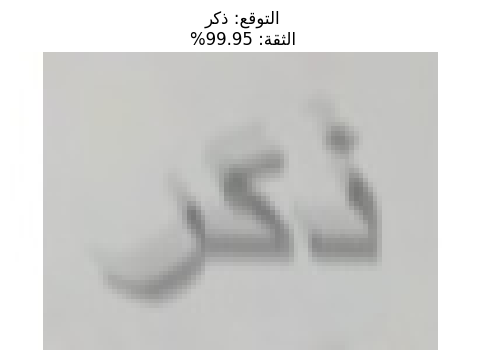

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_457_egypt_id_6_0.jpg


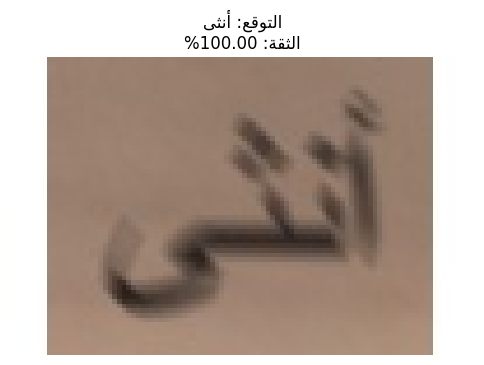

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_458_egypt_id_60_0.jpg


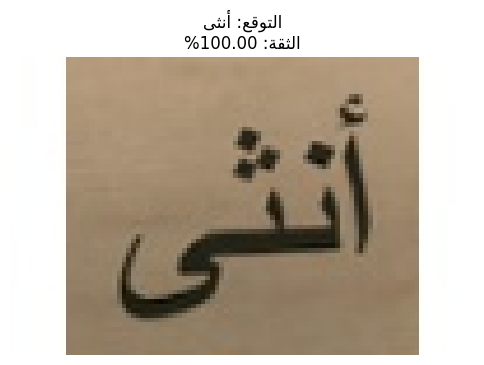

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_459_egypt_id_61_0.jpg


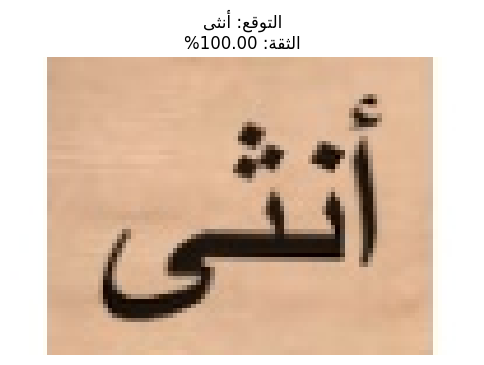

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_45_egypt_id_139_0.jpg


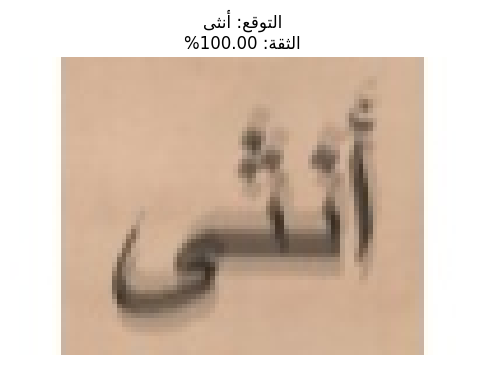

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_460_egypt_id_62_0.jpg


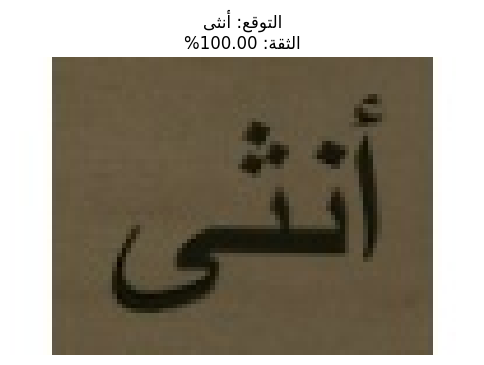

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_461_egypt_id_63_1.jpg


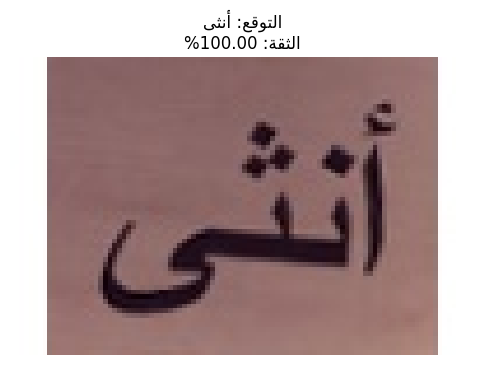

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_462_egypt_id_64_0.jpg


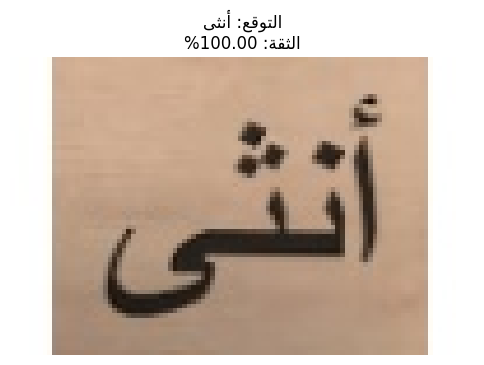

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_463_egypt_id_65_0.jpg


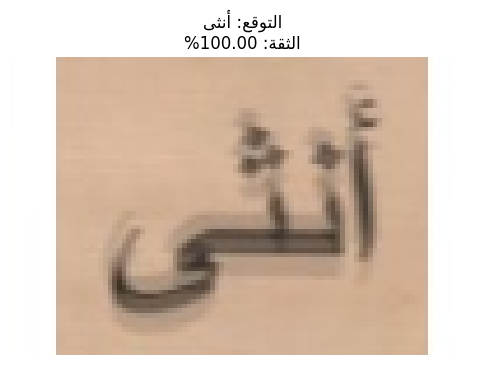

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_465_egypt_id_67_0.jpg


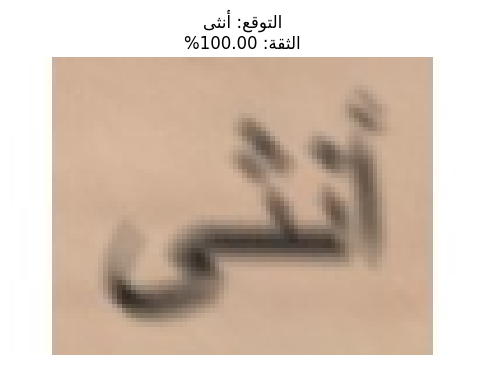

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_465_egypt_id_67_1.jpg


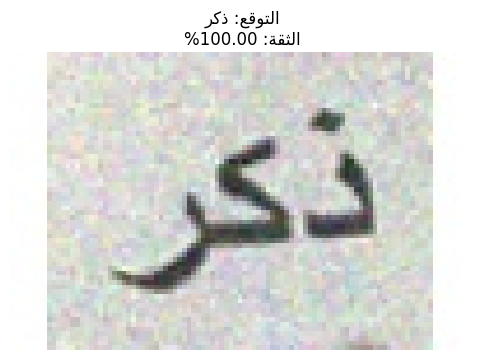

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_466_egypt_id_68_0.jpg


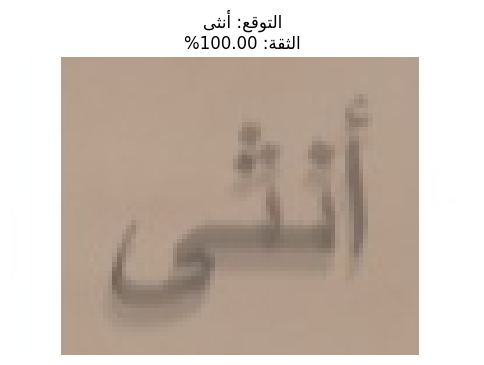

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_467_egypt_id_69_0.jpg


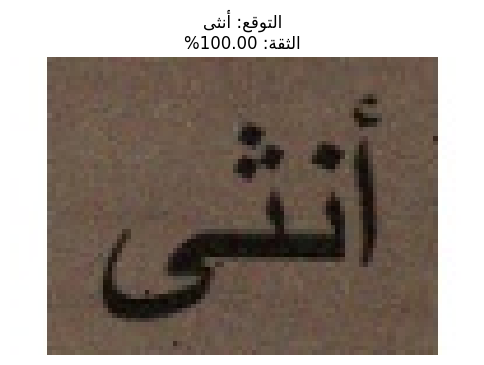

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_467_egypt_id_69_2.jpg


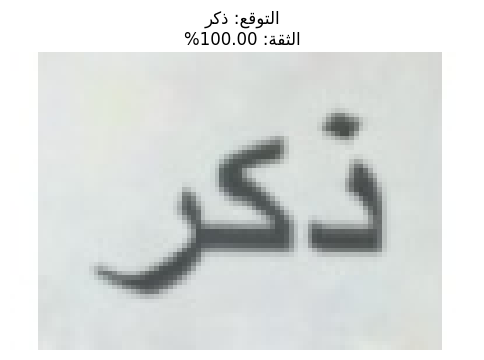

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_468_egypt_id_7_0.jpg


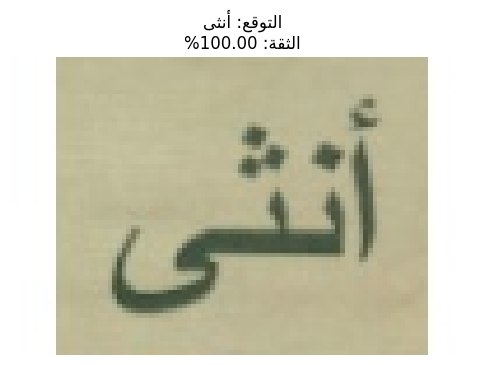

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_46_egypt_id_14_0.jpg


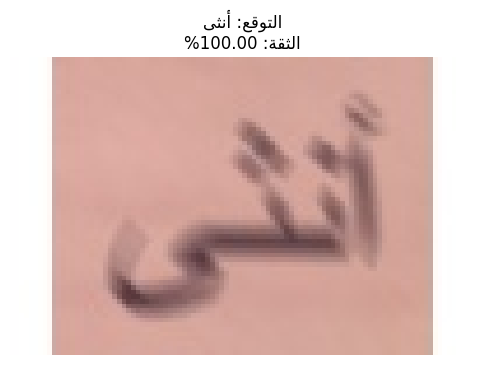

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_46_egypt_id_14_2.jpg


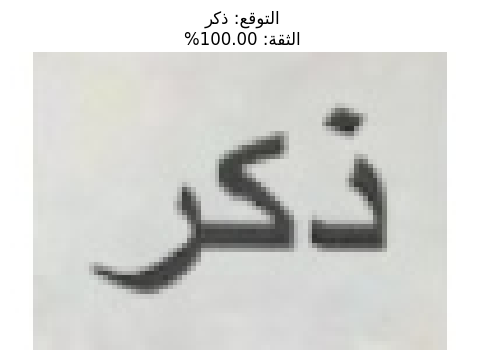

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_470_egypt_id_71_0.jpg


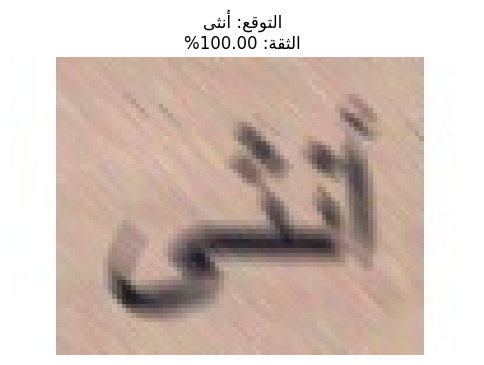

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_471_egypt_id_72_0.jpg


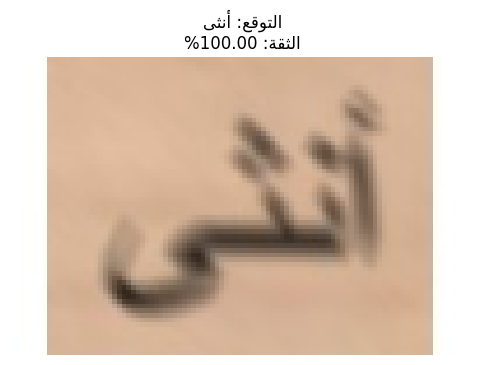

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_472_egypt_id_73_0.jpg


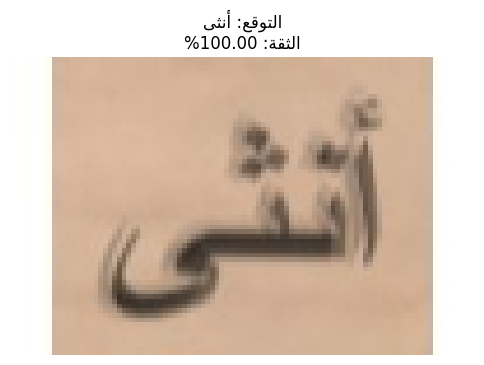

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_472_egypt_id_73_2.jpg


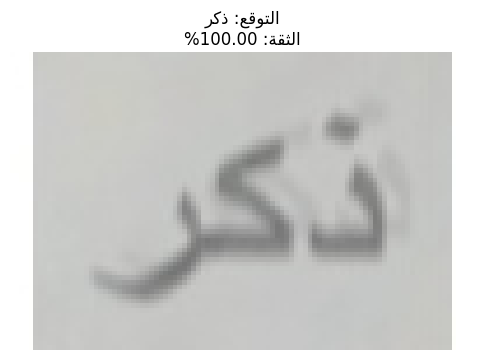

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_473_egypt_id_74_0.jpg


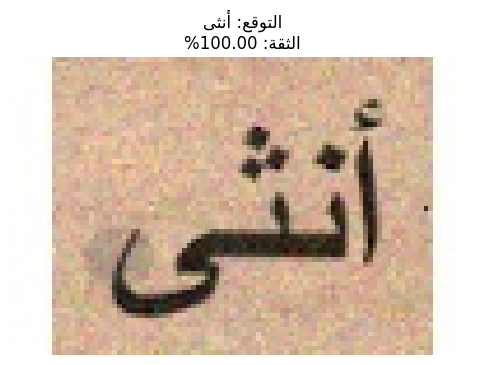

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_474_egypt_id_75_0.jpg


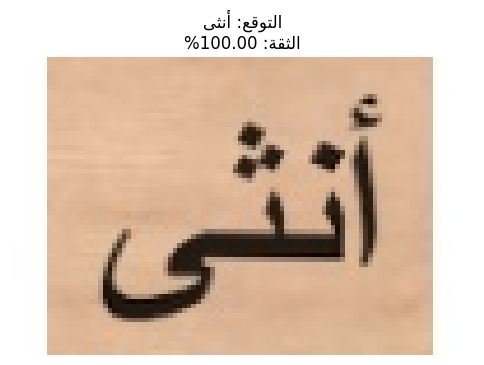

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_476_egypt_id_77_0.jpg


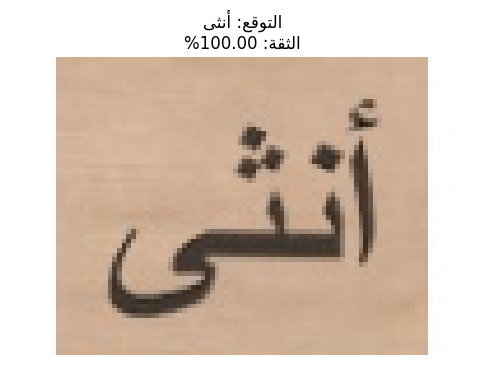

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_479_egypt_id_8_0.jpg


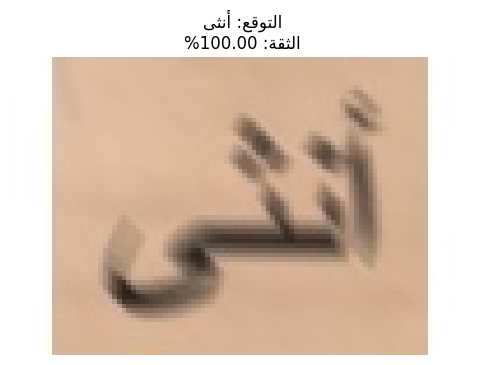

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_47_egypt_id_140_0.jpg


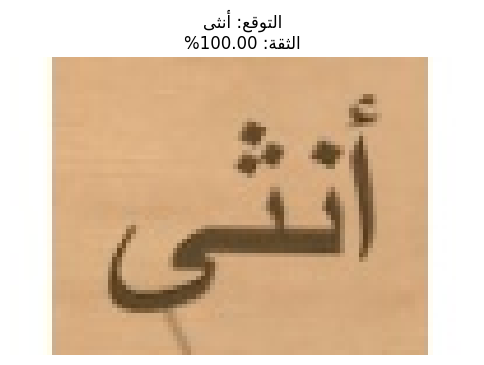

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_480_egypt_id_80_0.jpg


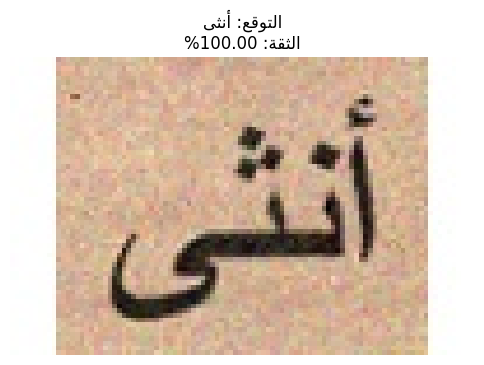

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_481_egypt_id_81_0.jpg


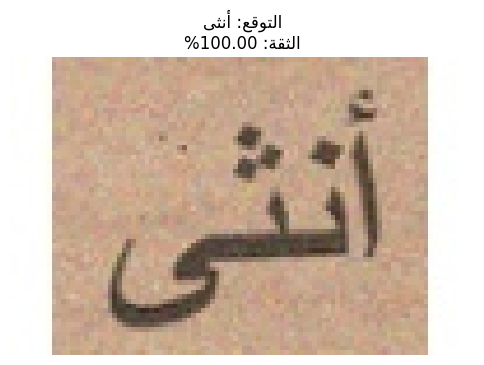

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_483_egypt_id_83_0.jpg


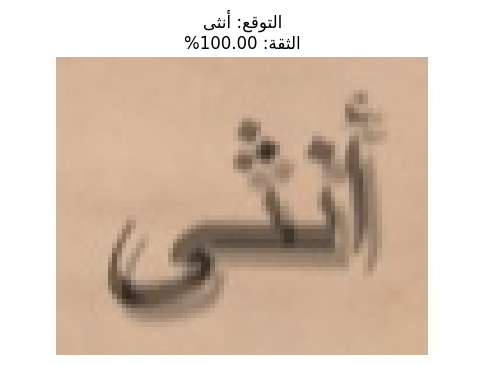

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_484_egypt_id_84_0.jpg


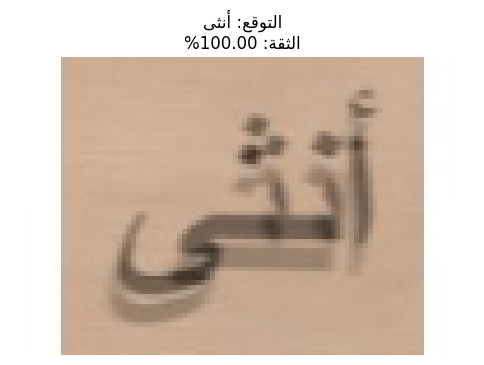

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_486_egypt_id_86_0.jpg


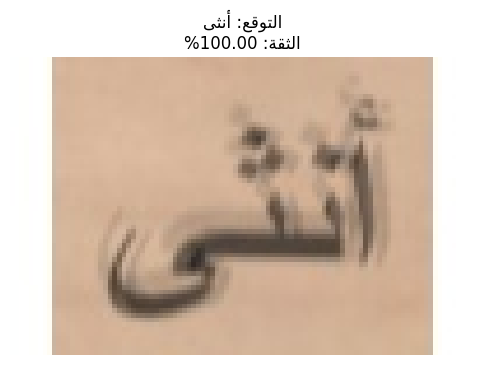

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_487_egypt_id_87_0.jpg


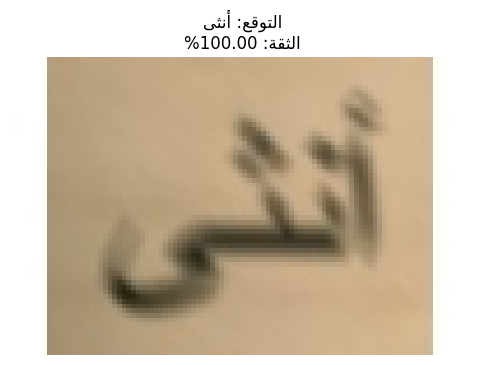

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_487_egypt_id_87_2.jpg


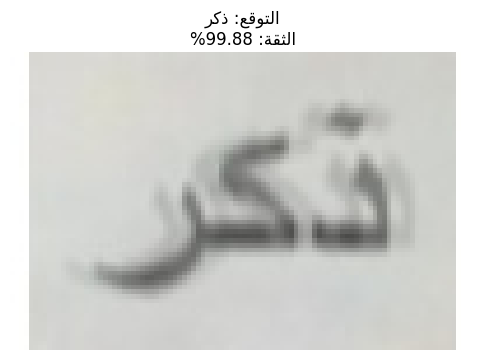

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_488_egypt_id_88_1.jpg


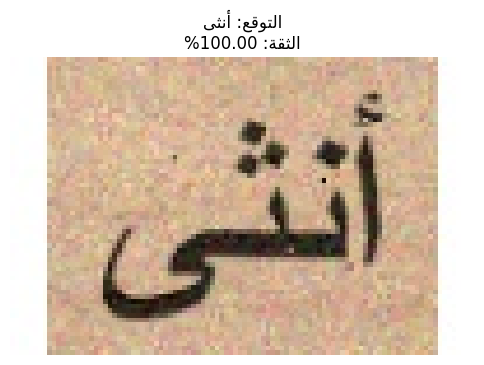

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_489_egypt_id_89_0.jpg


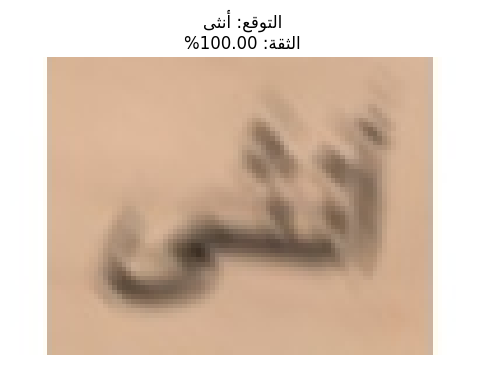

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_48_egypt_id_141_0.jpg


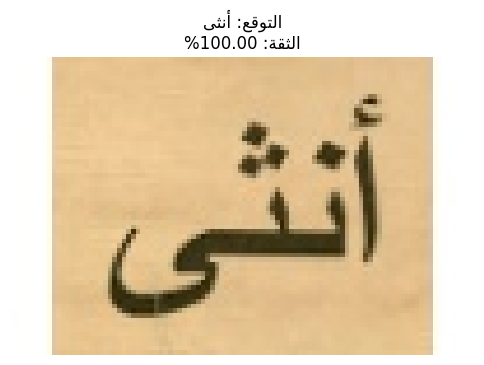

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_490_egypt_id_9_1.jpg


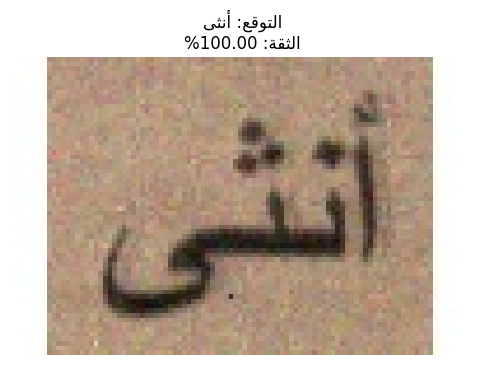

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_491_egypt_id_90_0.jpg


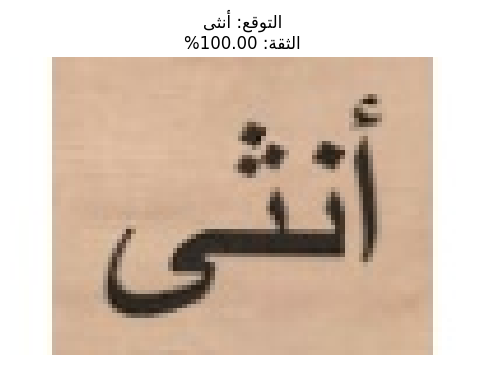

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_492_egypt_id_91_0.jpg


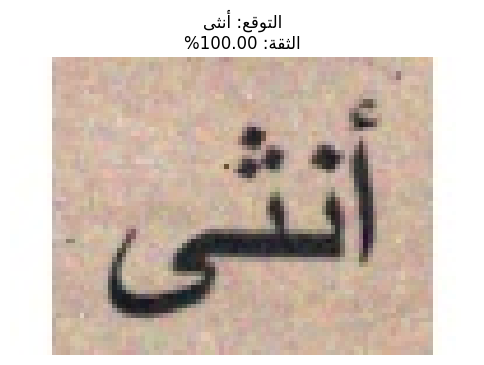

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_495_egypt_id_94_0.jpg


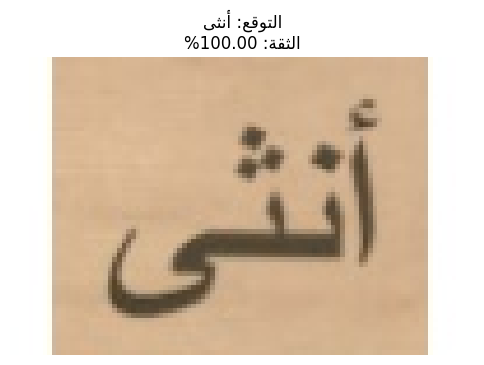

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_495_egypt_id_94_2.jpg


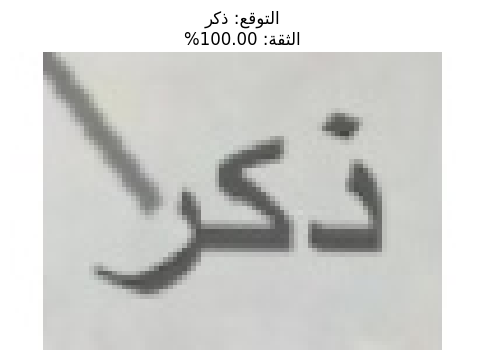

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_496_egypt_id_95_0.jpg


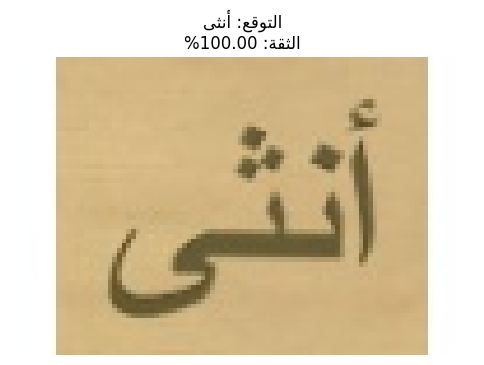

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_496_egypt_id_95_2.jpg


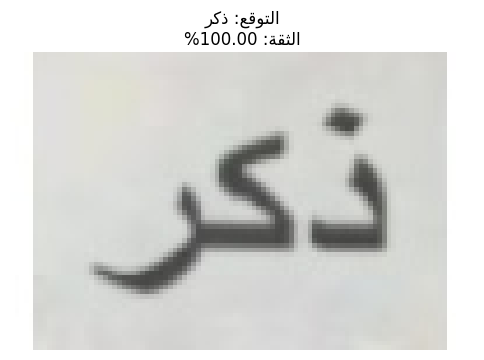

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_497_egypt_id_96_0.jpg


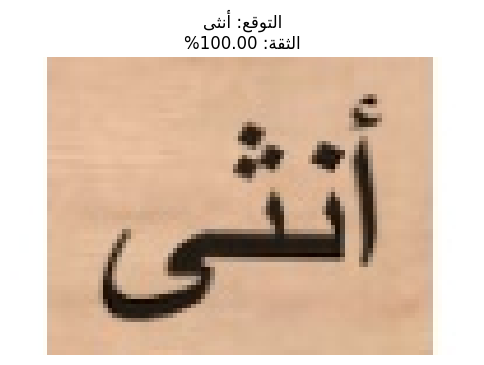

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_498_egypt_id_97_0.jpg


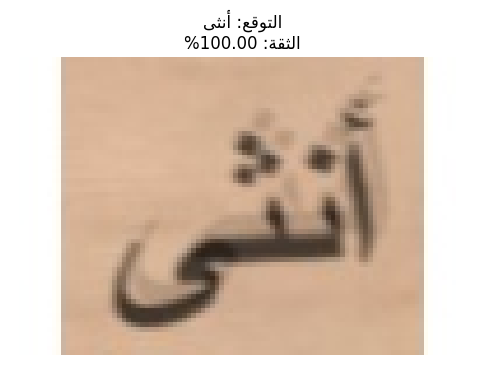

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_499_egypt_id_98_0.jpg


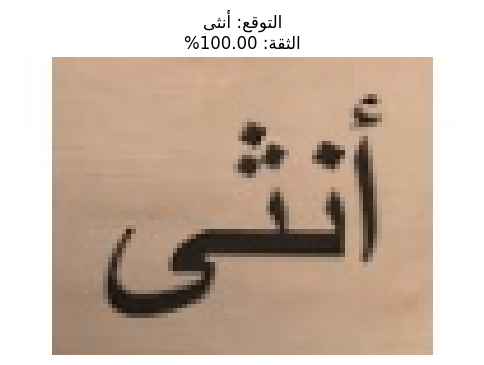

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_49_egypt_id_142_0.jpg


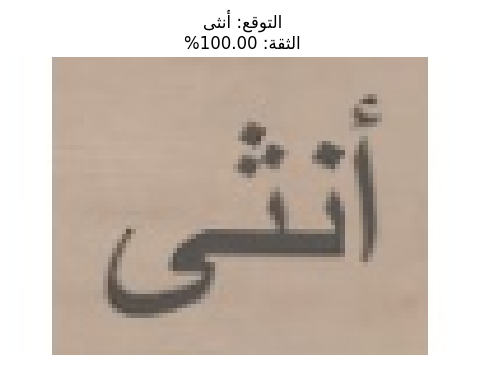

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_4_egypt_id_101_0.jpg


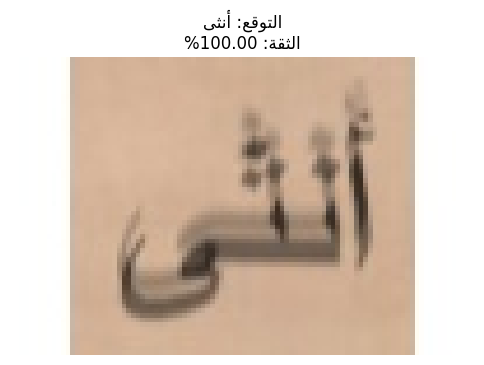

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_500_egypt_id_99_0.jpg


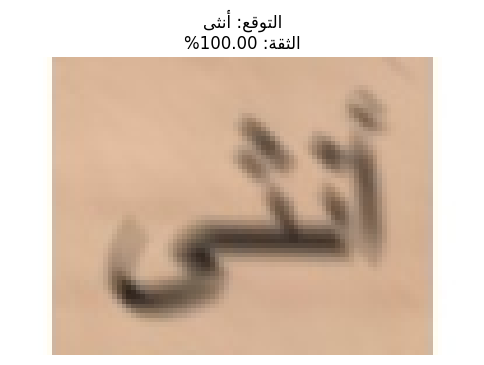

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_50_egypt_id_143_0.jpg


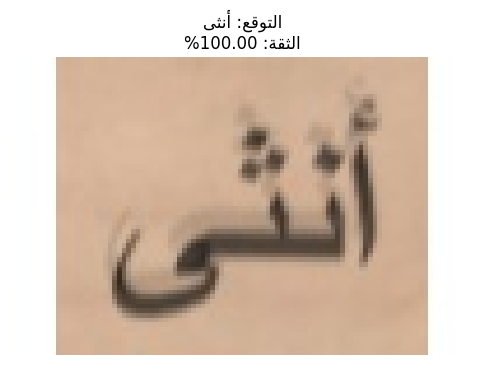

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_51_egypt_id_144_0.jpg


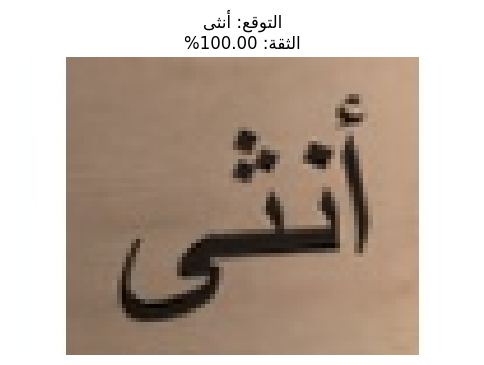

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_53_egypt_id_146_0.jpg


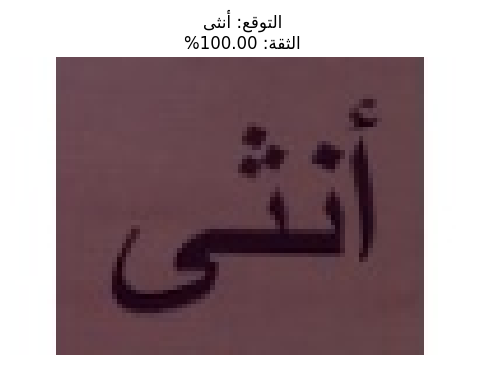

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_54_egypt_id_147_0.jpg


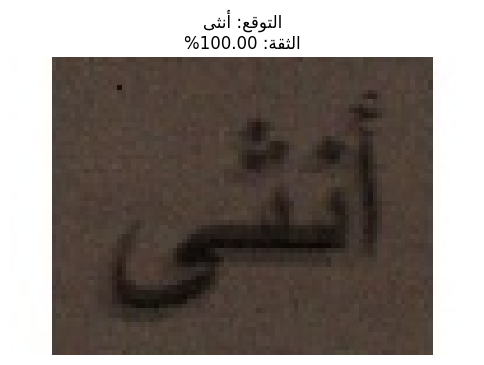

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_54_egypt_id_147_1.jpg


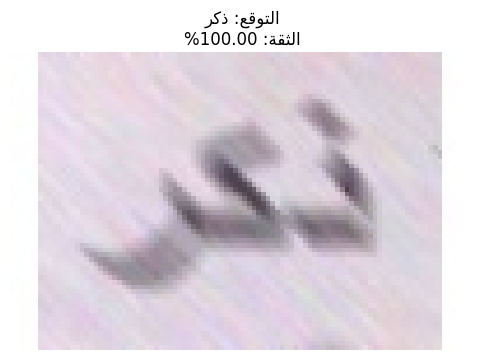

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_55_egypt_id_148_0.jpg


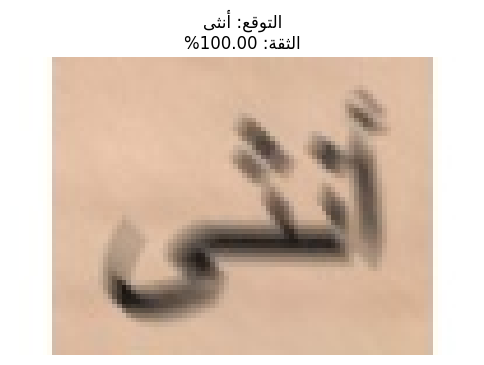

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_55_egypt_id_148_2.jpg


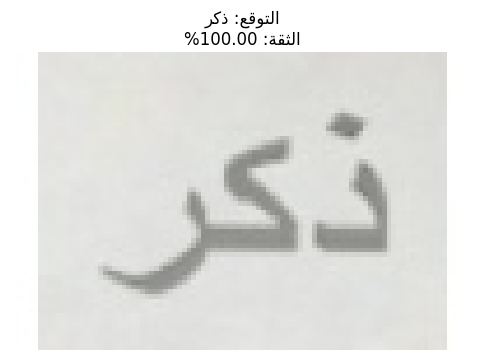

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_56_egypt_id_149_0.jpg


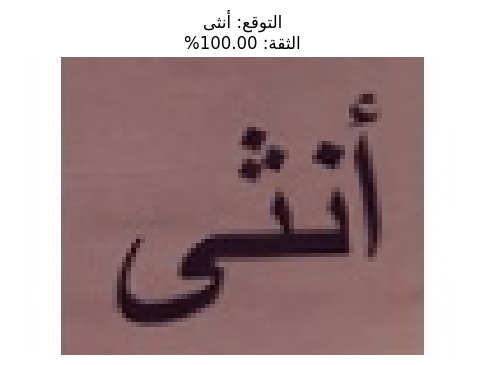

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_57_egypt_id_15_0.jpg


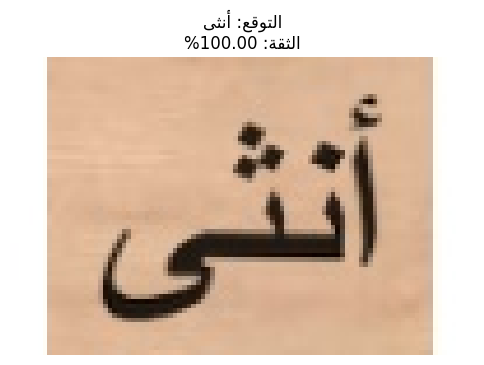

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_58_egypt_id_150_0.jpg


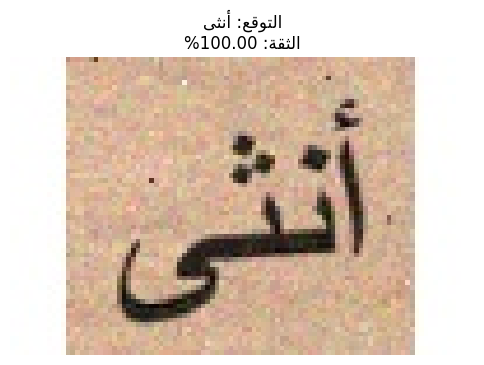

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_59_egypt_id_151_0.jpg


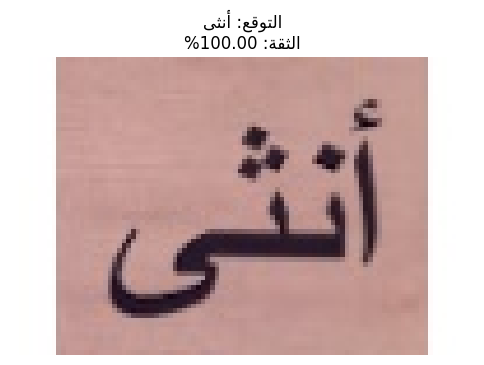

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_6_egypt_id_103_1.jpg


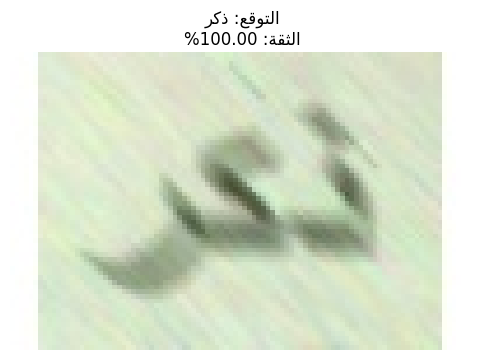

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_78_egypt_id_169_2.jpg


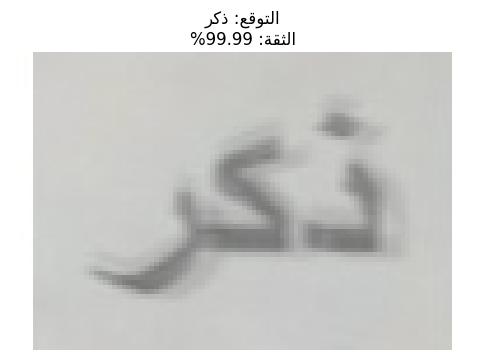

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_82_egypt_id_172_2.jpg


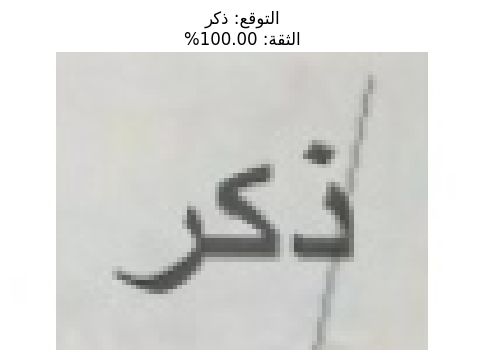

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\augmented_95_egypt_id_184_2.jpg


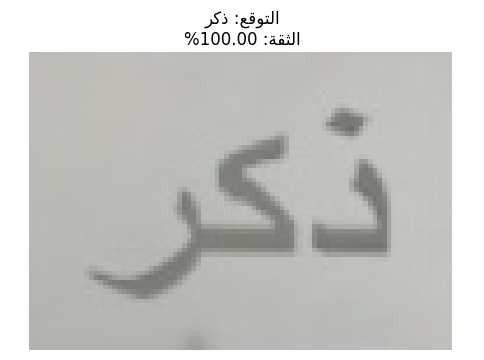

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_104_0.jpg


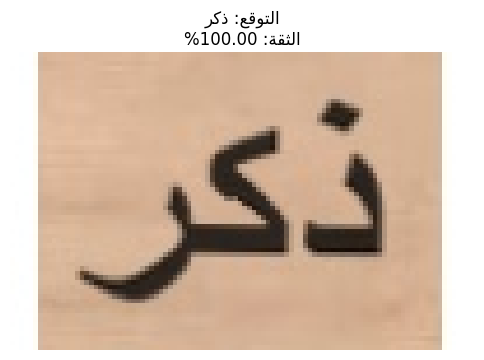

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_105_0.jpg


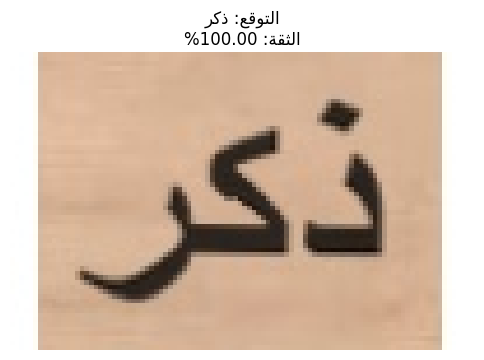

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_106_0.jpg


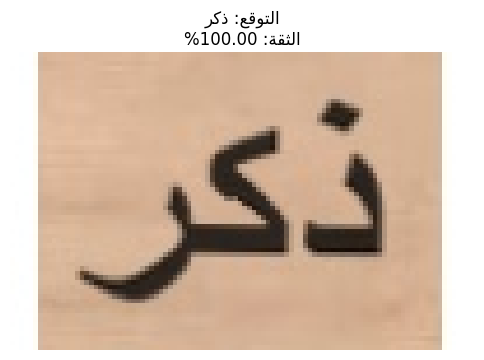

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_107_0.jpg


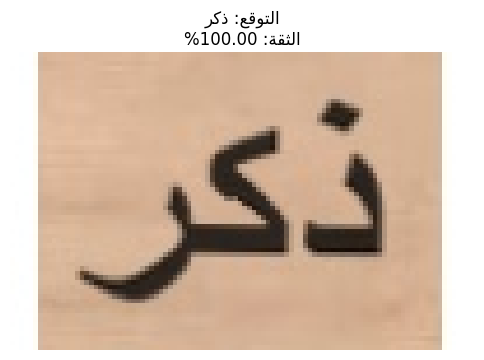

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_108_0.jpg


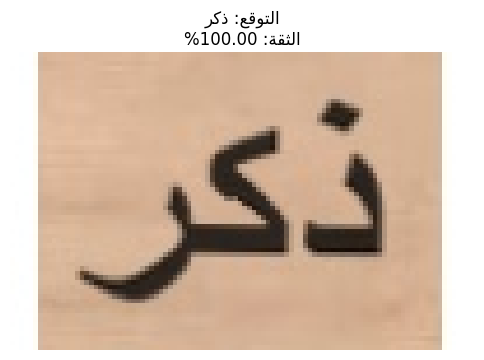

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_109_0.jpg


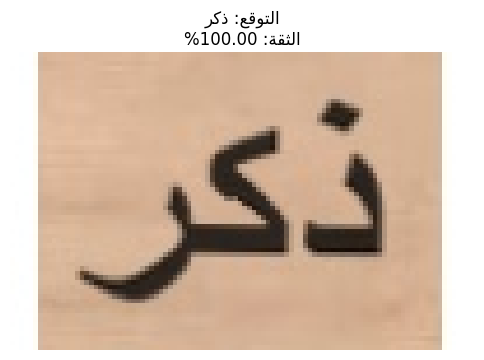

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_110_0.jpg


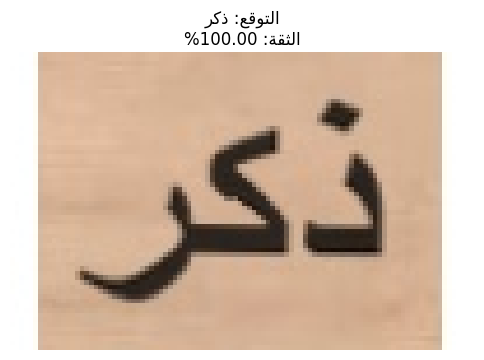

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_111_0.jpg


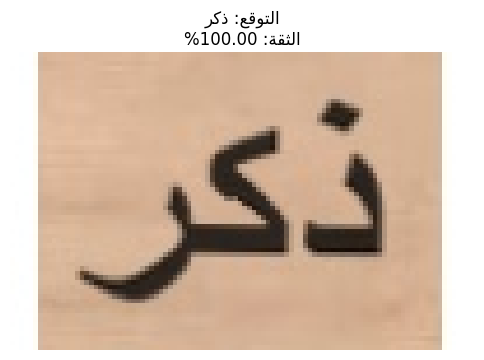

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_112_0.jpg


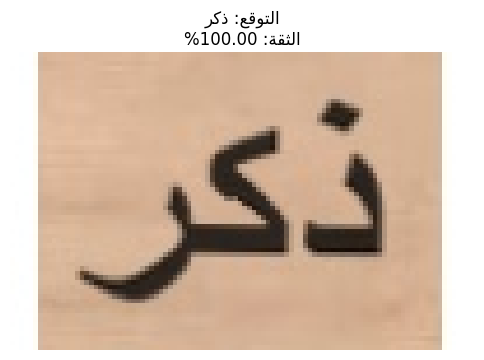

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_113_0.jpg


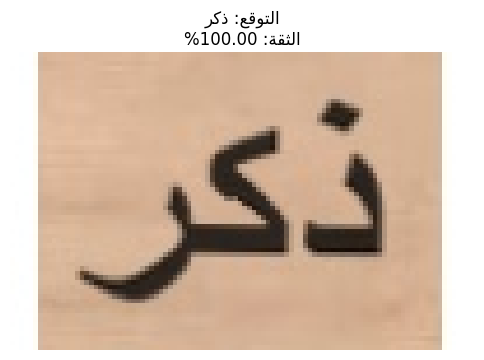

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_114_0.jpg


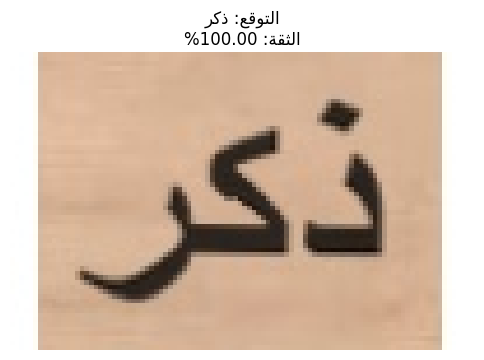

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_115_0.jpg


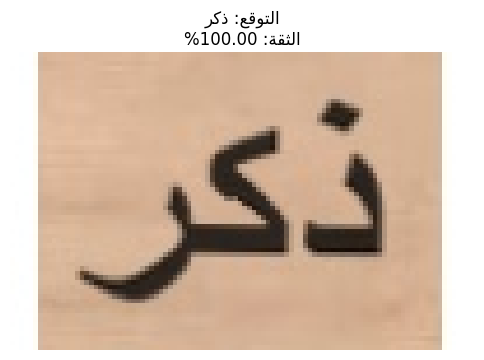

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_116_0.jpg


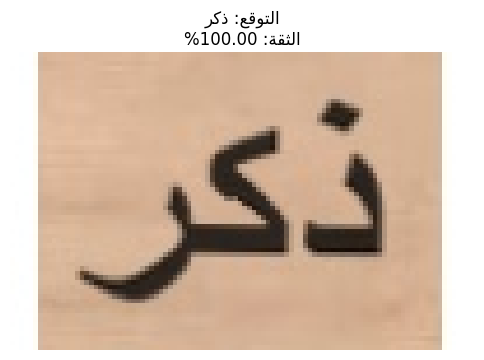

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_11_0.jpg


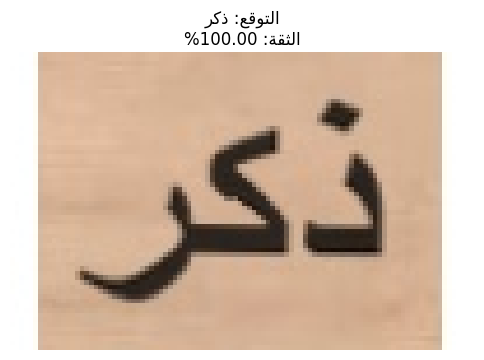

üîπ Processing: C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images\egypt_id_1_0.jpg


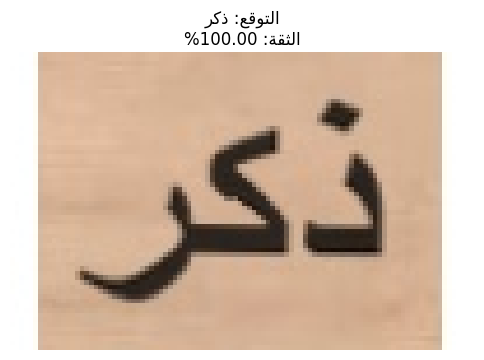

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pandas as pd

# ‚úÖ Import Arabic reshaping libraries
import arabic_reshaper
from bidi.algorithm import get_display

# ‚úÖ Arabic reshaping helper
def prepare_arabic(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

def predict_gender_on_folder(model_path, test_folder, output_csv='predictions.csv'):
    """
    Test a trained model on a folder of new ID images
    Args:
        model_path: Path to your saved .h5 or .keras model
        test_folder: Path to folder containing test images
        output_csv: Name for output predictions file
    """
    # Verify model path exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at: {model_path}. Please check the path.")
    
    # Verify test folder exists
    if not os.path.exists(test_folder):
        raise FileNotFoundError(f"Test folder not found at: {test_folder}")
    
    # Load the trained model
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"‚úÖ Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"‚ùå Error loading model: {str(e)}")
        return None
    
    # Class names (must match training order)
    class_names = ['ÿ£ŸÜÿ´Ÿâ', 'ÿ∞ŸÉÿ±']  # 0 for ÿ£ŸÜÿ´Ÿâ, 1 for ÿ∞ŸÉÿ±
    
    # Process all images in the folder
    results = []
    for img_file in os.listdir(test_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Load and preprocess image
                img_path = os.path.join(test_folder, img_file)
                print(f"üîπ Processing: {img_path}")
                
                img = load_img(img_path, target_size=(64, 100))  # Match training size
                img_array = img_to_array(img) / 255.0  # Normalize
                img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                
                # Make prediction
                prediction = model.predict(img_array, verbose=0)
                gender_prob = float(prediction[0][0])  # Get sigmoid probability
                gender_idx = int(gender_prob > 0.5)  # Threshold at 0.5
                gender = class_names[gender_idx]
                confidence = gender_prob if gender_idx == 1 else 1 - gender_prob
                #If prediction is female: confidence = 1 - gender_prob.
                #So you always get the chance that your prediction is correct.
                
                # Store results
                results.append({
                    'filename': img_file,
                    'prediction': gender,
                    'confidence': round(confidence, 4),
                    'prediction_raw': gender_prob
                })
                
                # Display the image with prediction in Arabic
                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                title_text = prepare_arabic(f"ÿßŸÑÿ™ŸàŸÇÿπ: {gender}\nÿßŸÑÿ´ŸÇÿ©: {confidence:.2%}")
                plt.title(title_text)
                plt.axis('off')
                plt.show()
                
            except Exception as e:
                print(f"‚ùå Error processing {img_file}: {str(e)}")
                results.append({
                    'filename': img_file,
                    'prediction': 'ERROR',
                    'confidence': 0,
                    'prediction_raw': 0
                })


if __name__ == "__main__":
    model_path = r"cv_results/best_gender_model.h5"
    test_images_folder = r"C:\Users\alhas\Downloads\CNN_Text_Datasets_From_Generator\gender_test_images"
    
    # Verify paths before running
    print(f"Model path exists: {os.path.exists(model_path)}")
    print(f"Test folder exists: {os.path.exists(test_images_folder)}")
    
    if os.path.exists(model_path) and os.path.exists(test_images_folder):
        predictions = predict_gender_on_folder(
            model_path,
            test_images_folder,
            output_csv='gender_predictions.csv'
        )
        if predictions is not None:
            print(predictions.head())
    else:
        print("\n‚ùå Error: Missing files or directories. Please check paths.")
